In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from keras import backend as K

%matplotlib inline

# Fix random seed for reproducibility
seed = 42

Using TensorFlow backend.


# Loading and Preprocessing Data 

In [0]:
data = pd.read_csv('hourly.csv')
data_datetime = pd.read_csv('hourly.csv', parse_dates=['dteday'], index_col=0)

# Drop data columns that are overlapping
data = data.drop(['atemp', 'casual', 'registered'], axis=1)
data_datetime = data_datetime.drop(['atemp', 'casual', 'registered'], axis=1)

# Rename the dataframe columns to be more readable
data.columns = ['Day', 'Season', 'Year', 'Month', 'Hour', 'Holiday', 'Weekday', 'Working Day', 'Weather Situation',
               'Temperature', 'Humidity', 'Wind Speed', 'Count']

data_datetime.columns = ['Season', 'Year', 'Month', 'Hour', 'Holiday', 'Weekday', 'Working Day', 'Weather Situation',
               'Temperature', 'Humidity', 'Wind Speed', 'Count']

# # Convert Date in 'dd/mm/yyyy' format to day of month
data['Day'] = [int(s[:2]) for s in data.Day] 

data.head()

,Day,Season,Year,Month,Hour,Holiday,Weekday,Working Day,Weather Situation,Temperature,Humidity,Wind Speed,Count
0,1,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
1,1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40
2,1,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32
3,1,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13
4,1,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1


In [0]:
data_datetime.head()

,Season,Year,Month,Hour,Holiday,Weekday,Working Day,Weather Situation,Temperature,Humidity,Wind Speed,Count
dteday,,,,,,,,,,,,
2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40
2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32
2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13
2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1


## Exploratory Data Analysis

Are there any null values in the data? False
Are there only positive values in the data? True
Number of datapoints: 17379


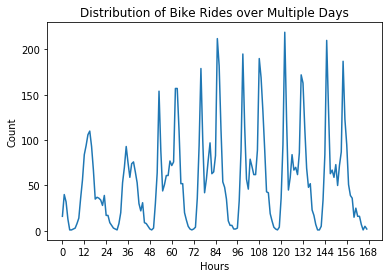

Correlation between Count and Season: 0.18
Correlation between Count and Year: 0.25
Correlation between Count and Month: 0.12
Correlation between Count and Hour: 0.39
Correlation between Count and Holiday: -0.03
Correlation between Count and Weekday: 0.03
Correlation between Count and Working Day: 0.03
Correlation between Count and Weather Situation: -0.14
Correlation between Count and Temperature: 0.40
Correlation between Count and Humidity: -0.32
Correlation between Count and Wind Speed: 0.09

Correlation between Season and Year: -0.01
Correlation between Season and Month: 0.83
Correlation between Season and Hour: -0.01
Correlation between Season and Holiday: -0.01
Correlation between Season and Weekday: -0.00
Correlation between Season and Working Day: 0.01
Correlation between Season and Weather Situation: -0.01
Correlation between Season and Temperature: 0.31
Correlation between Season and Humidity: 0.15

Correlation between Year and Month: -0.01
Correlation between Year and Hour: 

In [0]:
# Check Null values
print("Are there any null values in the data?", data.isnull().values.any())

# Check negative values
print("Are there only positive values in the data?", (data.values.all() >= 0))

# Number of datapoints
print("Number of datapoints:", len(data.Count.values.tolist()))

# Visualize the hourly data
plt.title('Distribution of Bike Rides over Multiple Days')
plt.plot([x for x in range(168)],data.Count[:168])
plt.xlabel("Hours")
plt.ylabel("Count")
plt.xticks(np.arange(0, 169, step=12))
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
plt.show()

# Compute correlation between each independent variable and the dependent variable
ind_variables = ['Season','Year','Month','Hour','Holiday','Weekday','Working Day','Weather Situation','Temperature',
           'Humidity','Wind Speed']
for feature in ind_variables:
    print("Correlation between Count and %s: %.2f" % (feature, data.Count.corr(data[feature])))
    
print("")

# Compute correlation between independent variables
for i in range(len(ind_variables) - 1):
    for j in range(i + 1, len(ind_variables)-1):
        print("Correlation between %s and %s: %.2f" % (ind_variables[i], ind_variables[j], 
                                                       data[ind_variables[i]].corr(data[ind_variables[j]])))
    print("")

In [0]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Day,Season,Year,Month,Hour,Holiday,Weekday,Working Day,Weather Situation,Temperature,Humidity,Wind Speed,Count
Day,1,-0.0031,0.0021,0.0079,0.0015,-0.01,0.0021,0.0086,-0.0039,0.027,0.026,0.011,-0.0043
Season,-0.0031,1,-0.011,0.83,-0.0061,-0.0096,-0.0023,0.014,-0.015,0.31,0.15,-0.15,0.18
Year,0.0021,-0.011,1,-0.01,-0.0039,0.0067,-0.0045,-0.0022,-0.019,0.041,-0.084,-0.0087,0.25
Month,0.0079,0.83,-0.01,1,-0.0058,0.018,0.01,-0.0035,0.0054,0.2,0.16,-0.14,0.12
Hour,0.0015,-0.0061,-0.0039,-0.0058,1,0.00048,-0.0035,0.0023,-0.02,0.14,-0.28,0.14,0.39
Holiday,-0.01,-0.0096,0.0067,0.018,0.00048,1,-0.1,-0.25,-0.017,-0.027,-0.011,0.004,-0.031
Weekday,0.0021,-0.0023,-0.0045,0.01,-0.0035,-0.1,1,0.036,0.0033,-0.0018,-0.037,0.012,0.027
Working Day,0.0086,0.014,-0.0022,-0.0035,0.0023,-0.25,0.036,1,0.045,0.055,0.016,-0.012,0.03
Weather Situation,-0.0039,-0.015,-0.019,0.0054,-0.02,-0.017,0.0033,0.045,1,-0.1,0.42,0.026,-0.14
Temperature,0.027,0.31,0.041,0.2,0.14,-0.027,-0.0018,0.055,-0.1,1,-0.07,-0.023,0.4


The graph above shows that the regression is nonlinear, because a simple straight line will not suffice to explain the daily variation in the data. The mean squared error for using a linear regression method will likely be very high. There seems to be a long-term increase in count, which could be naturally explained by popularity growth of the bike sharing service over time.

Independently, features such as hour of day, temperature and humidity has the strongest correlation with count, while there are features that are almost not correlated with count at all, for instance, weekday, working day and holiday. This presents an opportunity for principal component analysis to reduce dimensions in the features and address the curse of dimensionality, which may reduce efficacy of our neural network model (and other models applied later in this paper) at high-dimensions since high levels of noise is also incorporated during model training.

For the other factors, their correlations are quite straightforward with nothing surprising. For instance, season is highly correlated with month while year has zero correlation with whether or not it is a working day. This seems to suggest that the data is rather well collected and makes empirical sense. Doing this step allows us to perform due diligence on the dataset instead of assuming that the dataset is perfect without any fact-checking.

## Normalize Quantified Variables

In [0]:
# Normalize continuous variables such that large and small values are weighted equally
quant_features = ['Temperature', 'Humidity', 'Wind Speed']

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    # Take each data point, subtract mean and divide by standard deviation
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean) / std

# for LSTM
from sklearn.preprocessing import RobustScaler
f_columns = ['Temperature', 'Humidity', 'Wind Speed']
f_transformer = RobustScaler()

f_transformer = f_transformer.fit(data_datetime[f_columns].to_numpy())

data_datetime.loc[:, f_columns] = f_transformer.transform(
  data_datetime[f_columns].to_numpy()
)

# Splitting data into training, testing and validation set

Since neural networks have a large number of parameters, it makes sense to separate a validation set from the testing set that is catered to improve the hyperparameters at each epoch. Therefore, we split our training, testing and validation data with a 70/15/15 split.

In [0]:
# Split features and labels into training, testing and validation set
features, labels = np.split(data,[-1],axis=1)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, 
                                                                            random_state = seed)

# Validation data is used to improve hyperparameters during training
test_features, val_features, test_labels, val_labels = train_test_split(test_features, test_labels, test_size = 0.5,
                                                                       random_state = seed)

features_dt, labels_dt = np.split(data_datetime,[-1],axis=1)
train_features_dt, test_features_dt, train_labels_dt, test_labels_dt = train_test_split(features_dt, labels_dt, test_size = 0.3, 
                                                                            random_state = seed)

test_features_dt, val_features_dt, test_labels_dt, val_labels_dt = train_test_split(test_features_dt, test_labels_dt, test_size = 0.5,
                                                                       random_state = seed)

# To check size of each dataset
# print train_features.shape
# print train_labels.shape
# print test_features.shape
# print test_labels.shape
# print val_features.shape
# print val_labels.shape

# Creating and Training a Feed-forward Neural Network

In feed-forward architectures, information flows from one layer to the layer directly after. The first layer takes in inputs (a mix of numerical and categorical data as in this project) that is fed to its subsequent layers, while the final layer produces the output (a numerical prediction of count of bikes). The middle layers (if any) are called hidden layers because they do not directly interact with the external world but only information obtained from the input layer. At each layer, there is a specified number of neurons with an action potential that triggers an output under certain activation circumstances (e.g. if the input is non-negative). 

For our regression problem, we do not use any activation function that compresses its inputs since we want a numerical prediction. We also want this output to be on a continuous range of integers, therefore we simply have one neuron that outputs whatever its inputs were.

## Single Hidden Layer Neural Network

The function NeuralNetwork generates a model with one input layer (of similar dimension to training features), one hidden layer, one sigmoid activation layer, and one output layer. NeuralNetwork also configures the learning process, using keras's built-in Mean Squared Error as the loss function that is optimized at each epoch. I attempted to define my own R2 scoring function as the loss function though keras failed to minimize its inverse (to maximize the original). I also defined a negative R2-score that did not work very effectively as well.

Mean Squared Error is the next best alternative as a loss function, since it minimizes the squared distance between the model prediction and actual values. Large differences are penalized more heavily as compared Mean Absolute Error, which is important to really improve our regression algorithm.

In [0]:
def NeuralNetwork():
    # Instantiate neural network object
    model = Sequential()

    # Add fully connected layer with a sigmoid activation function
    model.add(Dense(units=50, activation='sigmoid', input_shape=(train_features.shape[1],)))

    # Add fully connected layer with no activation function
    model.add(Dense(units=1))

    # Configure the learning process
    model.compile(loss='mse', optimizer='adam')
    
    return model

model_test = NeuralNetwork()
print(model_test.summary())





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Train neural network
callbacks = [EarlyStopping(monitor='val_loss', min_delta = 0.001, patience = 10, verbose = 0)]

model = NeuralNetwork()

history = model.fit(train_features, train_labels, epochs = 8000, verbose = 1, batch_size = 32,
                    validation_data = (val_features, val_labels), callbacks = callbacks)

# Using model to predict train labels from its features
pred_training = model.predict(train_features, verbose = 0)
pred_testing = model.predict(test_features, verbose = 0)

print("Model Results:")
print("Mean Squared Error on Training Set: %.2f" % mean_squared_error(train_labels, pred_training))
print("R-squared Score on Training Set: %.2f" % r2_score(train_labels, pred_training))
print("Mean Squared Error on Training Set: %.2f" % mean_squared_error(test_labels, pred_testing))
print("R-squared Score on Training Set: %.2f" % r2_score(test_labels, pred_testing))




Train on 12165 samples, validate on 2607 samples
Epoch 1/8000





12165/12165 [==============================] - 1s 53us/step - loss: 66358.5704 - val_loss: 59386.4376
Epoch 2/8000
12165/12165 [==============================] - 0s 35us/step - loss: 61518.1157 - val_loss: 55504.3118
Epoch 3/8000
12165/12165 [==============================] - 0s 36us/step - loss: 57740.8230 - val_loss: 52079.5114
Epoch 4/8000
12165/12165 [==============================] - 0s 35us/step - loss: 54382.5614 - val_loss: 48871.5045
Epoch 5/8000
12165/12165 [==============================] - 0s 36us/step - loss: 51173.9092 - val_loss: 45941.2072
Epoch 6/8000
12165/12165 [==============================] - 0s 37us/step - loss: 48287.4220 - val_loss: 43279.8852
Epoch 7/8000
12165/12165 [==============================] - 0s 38us/step - loss: 45629.8523 - val_loss: 40788.6480
Epoch 8/8000
12165/12165 [==============================] - 0s 35us/step - loss: 43100.2416 - val_loss: 38350.6699
Epoch 9/8000
12165/1216

##  Creating a Deeper Neural Network

Even though deep learning is not the goal of this final project, it is nevertheless a powerful trait of Neural Networks that we can harnness. Using NeuralNetwork2, we will create an identical neural network as above but with an additional layer with a ReLU activation function. Using ReLU is fine since our dataset does not contain any negative values (as we initially checked). 

In [0]:
def NeuralNetwork2():
    model2 = Sequential()
    model2.add(Dense(units=50, activation='sigmoid', input_shape=(train_features.shape[1],)))   
    model2.add(Dense(units = 25, activation = 'relu'))
    model2.add(Dense(units=1))
    model2.compile(loss='mse', optimizer='adam')
    return model2

model2_test = NeuralNetwork2()
print(model2_test.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                650       
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 1,951
Trainable params: 1,951
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Train neural network
model2 = NeuralNetwork2()

model2.fit(train_features, train_labels, epochs = 8000, verbose = 1, batch_size = 32,
                    validation_data = (val_features, val_labels), callbacks = callbacks)

pred_training_2 = model2.predict(train_features, verbose = 0)
pred_testing_2 = model2.predict(test_features, verbose = 0)

print("Model Results:")
print("Mean Squared Error on Training Set: %.2f" % mean_squared_error(train_labels, pred_training_2))
print("R-squared Score on Training Set: %.2f" % r2_score(train_labels, pred_training_2))
print("Mean Squared Error on Testing Set: %.2f" % mean_squared_error(test_labels, pred_testing_2))
print("R-squared Score on Testing Set: %.2f" % r2_score(test_labels, pred_testing_2))

Train on 12165 samples, validate on 2607 samples
Epoch 1/8000
12165/12165 [==============================] - 1s 61us/step - loss: 48548.7930 - val_loss: 26930.7241
Epoch 2/8000
12165/12165 [==============================] - 0s 39us/step - loss: 25149.9142 - val_loss: 20271.5032
Epoch 3/8000
12165/12165 [==============================] - 0s 39us/step - loss: 20912.7621 - val_loss: 18102.8599
Epoch 4/8000
12165/12165 [==============================] - 0s 40us/step - loss: 18998.3244 - val_loss: 16759.5515
Epoch 5/8000
12165/12165 [==============================] - 0s 40us/step - loss: 17818.8405 - val_loss: 15986.8615
Epoch 6/8000
12165/12165 [==============================] - 0s 39us/step - loss: 17140.3519 - val_loss: 15592.7527
Epoch 7/8000
12165/12165 [==============================] - 0s 39us/step - loss: 16727.8431 - val_loss: 15361.3725
Epoch 8/8000
12165/12165 [==============================] - 0s 39us/step - loss: 16447.8254 - val_loss: 15229.7263
Epoch 9/8000
12165/12165 [=====

Subsequently, this increased the R-squared score of the model by 0.10 and reduced mean squared error by approximately 54% on the same split of training and testing set. However, the number of parameters also greatly increased.

This is an impressive feat using deep learning, but I have decided not to pursue a deeeper neural network for this project. I will work with NeuralNetwork2 because its predictive power is very strong (R2 = 0.91) and I can compare it with powerful tree-based regressors such as Random Forest Regressor in the next part of this paper.

I tried further adding another layer, but the model performance is similar. Specifically, adding another sigmoid or ReLU activation layer did not increase the R-squared score. In other words, the (even) deeper model did not increase the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

## LSTM vs. Feedforward

We can use a LSTM model to see if they improve our predictions

In [0]:
from keras.layers import LSTM, Bidirectional, Dropout

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1
LSTM_train_X, LSTM_train_Y = create_dataset(train_features_dt, train_labels_dt, time_steps)
LSTM_test_X, LSTM_test_Y = create_dataset(test_features_dt, test_labels_dt, time_steps)
LSTM_val_X, LSTM_val_Y = create_dataset(val_features_dt, val_labels_dt, time_steps)

In [0]:
LSTM_train_X.shape

(12164, 1, 11)

In [0]:
def NeuralNetwork3():
    model = Sequential()
    model.add(
      Bidirectional(
        LSTM(
          units=256,
          input_shape=(LSTM_train_X.shape[1], LSTM_train_X.shape[2])
        )
      )
    )
    model.add(Dense(units = 25, activation = 'relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

In [0]:
# Train neural network
model3 = NeuralNetwork3()

model3.fit(LSTM_train_X, LSTM_train_Y, epochs = 8000, verbose = 1, batch_size = 32,
                    validation_data = (LSTM_val_X, LSTM_val_Y), callbacks = callbacks, shuffle=False)

pred_training_3 = model3.predict(LSTM_train_X, verbose = 0)
pred_testing_3 = model3.predict(LSTM_test_X, verbose = 0)

print("Model Results:")
print("Mean Squared Error on Training Set: %.2f" % mean_squared_error(LSTM_train_Y, pred_training_3))
print("R-squared Score on Training Set: %.2f" % r2_score(LSTM_train_Y, pred_training_3))
print("Mean Squared Error on Testing Set: %.2f" % mean_squared_error(LSTM_test_Y, pred_testing_3))
print("R-squared Score on Testing Set: %.2f" % r2_score(LSTM_test_Y, pred_testing_3))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 12164 samples, validate on 2606 samples
Epoch 1/8000
12164/12164 [==============================] - 10s 829us/step - loss: 42813.9228 - val_loss: 31073.1368
Epoch 2/8000
12164/12164 [==============================] - 9s 707us/step - loss: 34665.1844 - val_loss: 30951.5046
Epoch 3/8000
12164/12164 [==============================] - 8s 685us/step - loss: 34743.5657 - val_loss: 30934.9615
Epoch 4/8000
12164/12164 [==============================] - 9s 711us/step - loss: 34465.5261 - val_loss: 30891.9186
Epoch 5/8000
12164/12164 [==============================] - 9s 707us/step - loss: 34816.1842 - val_loss: 30864.7636
Epoch 6/8000
12164/12164 [==============================] - 9s 704us/step - loss: 34868.6197 - val_loss: 30903.2630
Epoch 7/8000
12164/12164 [==================

### Visualizing Predictions from NeuralNetwork2

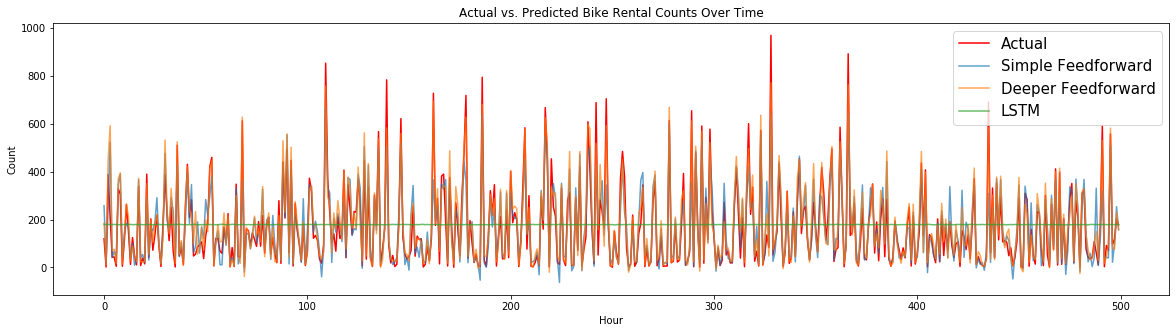

In [0]:
def plot_predictions(n=500):
  time = [i for i in range(n)]
  preds = [pred_testing, pred_testing_2, pred_testing_3]
  labels = ['Simple Feedforward', 'Deeper Feedforward', 'LSTM']

  # Visualize a 500-sized slice of predictions and actual bike rental counts
  plt.title("Actual vs. Predicted Bike Rental Counts Over Time")
  plt.plot(time[:500], test_labels[:n], c = 'red', label = "Actual")

  for model in range(len(preds)):
    plt.plot(time[:500], preds[model][:n], label = labels[model], alpha = 0.7)
  plt.locator_params(axis='y',nbins = 6)
  plt.xlabel('Hour')
  plt.ylabel('Count')
  plt.legend(loc='upper right',prop={'size': 15})
  plt.show()

plot_predictions()
# To display the full test set:
# for i in range(500,3000,500):
#     plt.plot(time[i-500:i], test_labels[i-500:i], c = 'red', label = 'Actual')
#     plt.plot(time[i-500:i], pred[i-500:i], c = 'blue', label = 'Predicted')
#     plt.locator_params(axis='y',nbins = 6)
#     plt.xlabel('Time')
#     plt.ylabel('Count')
#     plt.legend(loc='upper right',prop={'size': 15})
#     plt.show()

# Using Cross Validation to Reduce Overfitting

To ensure that NeuralNetwork2 is generalizable beyond its initial training, we can perform K-fold cross validation on the model to finetune its hyperparameters by exposing the model to unique sets of training and testing data. This is a good technique to reduce overfitting of the model given a sufficiently large dataset (which we have). As a result, both the mean squared error and R-squared score of the model performed on testing set improved from before. 

Another method to reduce overfitting that could be used in Neural Network is Dropout. Dropout is a regularization technique that prevent complex co-adaptations on training data by randomly dropping some training units during training (with dropout rate usually between 0.2 and 0.5). However, the performance of this model did not improve when tested with various settings of Dropout. This is because the neural network is small and shallow relative to the dataset with only 4 hidden layers and 75 hidden nodes when dealing with a data size of 17,379. If the model capacity is already low, lowering it further by adding regularization will hurt performance hence Dropout regularization is not utilized in this model.

In [0]:
n_splits = 8

features_list = features.values
labels_list = labels.values
labels_list = np.reshape(labels_list, [len(labels_list),])

folds = list(StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed).split(features_list, 
                                                                                             labels_list))

for i, (train, test) in enumerate(folds):
    print("K-fold Number: %i / %i " % (i + 1, n_splits))
    train_features_cv = features_list[train]
    train_labels_cv = labels_list[train]
    test_features_cv = features_list[test]
    test_labels_cv = labels_list[test]

    model2.fit(train_features_cv, train_labels_cv, epochs = 8000, shuffle = True, verbose = 0, batch_size = 32,
              validation_data = (test_features_cv, test_labels_cv), callbacks = callbacks)

pred_cv = model2.predict(test_features_cv, verbose = 0)

print("Mean Squared Error on Testing Set: %.2f" % mean_squared_error(test_labels_cv, pred_cv))
print("R-squared Score on Testing Set: %.2f" % r2_score(test_labels_cv, pred_cv))

/Users/franklooi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


K-fold Number: 1 / 8 
K-fold Number: 2 / 8 
K-fold Number: 3 / 8 
K-fold Number: 4 / 8 
K-fold Number: 5 / 8 
K-fold Number: 6 / 8 
K-fold Number: 7 / 8 
K-fold Number: 8 / 8 
Mean Squared Error on Testing Set: 1698.05
R-squared Score on Testing Set: 0.92


# Compare Feedforward Neural Network with other Regressional Algorithms

After all the hardwork on the Neural Network to optimize its predictive power on the given dataset, it is time to pit it up against different algorithms! The line up includes a mix of linear regression models and ensembles such as the random forest regressor. 

Linear SVR - A Support Vector Regressor with a linear kernel
Linear Regression - A Regressor that finds a straight line of best fit over the data distribution
Random Forest Regressor - An ensemble of different regression trees that is used for nonlinear regression. Like the Neural Network, RFR is capable of handling feature engineering and extraction with superb runtimes.

We used PCA to moderately reduce dimensions in the data which may be helpful for LinearSVR and Linear Regression such that its performance is not affected by high dimensionality. The regression function takes care of running each model with the same training and testing sets and printing the model's performance.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

def regression(model, pca_true, n_components = 5):
    features_2d = features.values.reshape(-1,12)
    labels_2d = labels.values.reshape(-1,1)
    
    if model == RandomForestRegressor or model == LinearSVR:
        labels_2d = np.reshape(labels_2d,[len(labels_2d),])
        
    if pca_true:
        pca = PCA(n_components = n_components)
        features_2d = pca.fit_transform(features_2d)
        
    train_X, test_X, train_Y, test_Y = train_test_split(features_2d, labels_2d, test_size = 0.3, random_state = seed)
    
    if model == NeuralNetwork:
        model_pred = model2.predict(test_X)
    
    else:
        model = model()
        model = model.fit(train_X, train_Y)
        model_pred = model.predict(test_X)

    print("R-squared Score: %.2f" % r2_score(test_Y, model_pred))
    print("Mean Squared Error: %.2f" % mean_squared_error(test_Y, model_pred))

print("Linear Support Vector Regressor")
regression(LinearSVR, False)
regression(LinearSVR, True, 10)
regression(LinearSVR, True, 5)

print("\nLinear Regression")
regression(LinearRegression, False)
regression(LinearRegression, True, 10)
regression(LinearRegression, True, 5)

print("\nRandom Forest Regressor")
regression(RandomForestRegressor, False)    

print("\nNeural Network")
regression(NeuralNetwork, False)

Linear Support Vector Regressor
R-squared Score: 0.35
Mean Squared Error: 20663.78
R-squared Score: 0.34
Mean Squared Error: 20790.47
R-squared Score: 0.20
Mean Squared Error: 25159.22

Linear Regression
R-squared Score: 0.39
Mean Squared Error: 19403.13
R-squared Score: 0.38
Mean Squared Error: 19430.78
R-squared Score: 0.25
Mean Squared Error: 23731.91

Random Forest Regressor


/Users/franklooi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R-squared Score: 0.94
Mean Squared Error: 1926.89

Neural Network
R-squared Score: 0.94
Mean Squared Error: 1917.67


In [0]:
from xgboost import XGBRegressor

features_2d = features.values.reshape(-1,12)
labels_2d = labels.values.reshape(-1,1)

train_X, test_X, train_Y, test_Y = train_test_split(features_2d, labels_2d, test_size = 0.3, random_state = seed)

model = XGBRegressor()
model.fit(train_X, train_Y)
preds = model.predict(test_X)

print("R-squared Score: %.2f" % r2_score(test_Y, preds))
print("Mean Squared Error: %.2f" % mean_squared_error(test_Y, preds))

[22:26:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R-squared Score: 0.85
Mean Squared Error: 4621.06


## Final Results
This Neural Network proves itself to be a worthy rival of the Random Forest Regressor, an ensemble with a lot of work and resources put into it. Of course, this neural network have all the potential to beat Random Forest Regressor given the optimum settings including the type of neural network (recurrent, convolution), the network architecture (optimal number of hidden layers, activation functions, loss functions), and the training framework (number of epochs, batch size and iterations). At each stage, there is room for further engineering that would be beyond this project.

The downside of using a Feedforward Neural Network as compared to a Random Forest Regressor is the large amount of time required to fit and train the Neural Network in order to achieve a high predictive power. However, a Neural Network is much simpler to implement from scratch with keras and tensorflow as comapred to Random Forest Regressor, itself an ensemble of heavily optimized algorithms. 

## How did we do on the data?

The final form of the Feedforward Neural Network is consists of 4 hidden layers and 75 hidden nodes, which deals with a data size of 17,379. This network is subsequently trained with 70% of the dataset (~12,165) and learned to predict the number of bikes used at a bike-sharing service (count). Through this training, the model is able to explain 92% of variance in the count of the untrained dataset based on variance in the features, such as temperature, humidity, etc. 

In non-technical terms, our model has a high predictive power of the likely number of bikes used given the hourly factors in the data. This algorithm rivals the Random Forest Regressor, a popular algorithm in terms of model predictive power and in minimizing prediction error. Nevertheless, this simple network is not yet fully optimized and emerging types of network such as Long Short Term Memory Networks, Convolutional Networks, Recurrent Networks that promise to beat the performance of this network.